In [2]:
!pip install ultralytics -q
print('YOLO26 (ultralytics) ready')

YOLO26 (ultralytics) ready


In [3]:
from google.colab import drive
drive.mount('/content/drive')
print('Google Drive mounted')

Mounted at /content/drive
Google Drive mounted


In [4]:
import os

DRIVE_BASE  = '/content/drive/MyDrive/Obj_detection_segmentation'
VIDEO_NAME  = 'ball_perfect_tracking.mp4'
OUTPUT_NAME = 'ball_tracking_output_maybegood.mp4'

VIDEO_PATH  = os.path.join(DRIVE_BASE, VIDEO_NAME)
OUTPUT_PATH = os.path.join(DRIVE_BASE, OUTPUT_NAME)
LOCAL_RAW   = '/content/ball_raw.mp4'
LOCAL_H264  = '/content/ball_h264.mp4'

assert os.path.exists(VIDEO_PATH), (
    f'ERROR: Video not found at:\n   {VIDEO_PATH}\n'
    f'   Check the folder/filename in your Drive.'
)

size_mb = os.path.getsize(VIDEO_PATH) / 1e6
print(f'Video found  : {VIDEO_PATH}  ({size_mb:.1f} MB)')
print(f'Output path  : {OUTPUT_PATH}')

Video found  : /content/drive/MyDrive/Obj_detection_segmentation/ball_perfect_tracking.mp4  (3.3 MB)
Output path  : /content/drive/MyDrive/Obj_detection_segmentation/ball_tracking_output_maybegood.mp4


In [5]:
from ultralytics import YOLO

# YOLO26n = fastest  |  yolo26s / yolo26m = more accurate
model = YOLO('yolo26s.pt')

# COCO class 32 = 'sports ball'  (covers basketball)
BALL_CLASS_ID = 32
print(f'Model loaded: yolo26s.pt')
print(f'Tracking class -> [{BALL_CLASS_ID}] "{model.names[BALL_CLASS_ID]}"')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Model loaded: yolo26s.pt
Tracking class -> [32] "sports ball"


In [6]:
# Patch BoT-SORT config to hold tracks for longer during detection gaps
import yaml, ultralytics
botsort_path = ultralytics.__file__.replace('__init__.py',
               'cfg/trackers/botsort.yaml')

with open(botsort_path, 'r') as f:
    cfg = yaml.safe_load(f)

# cfg['track_buffer'] = 60   # hold a lost track for 60 frames (default is 30)
                            # at 30fps that's 2 full seconds of tolerance
cfg['track_buffer']     = 150   # 5s at 30fps — survives long passes
cfg['match_thresh']     = 0.6   # was 0.7 — more lenient re-matching
cfg['new_track_thresh'] = 0.10  # was 0.25 — picks up ball faster after gap

CUSTOM_TRACKER = '/content/botsort_custom.yaml'
with open(CUSTOM_TRACKER, 'w') as f:
    yaml.dump(cfg, f)

print(f'Custom tracker saved — track_buffer: {cfg["track_buffer"]} frames')

Custom tracker saved — track_buffer: 150 frames


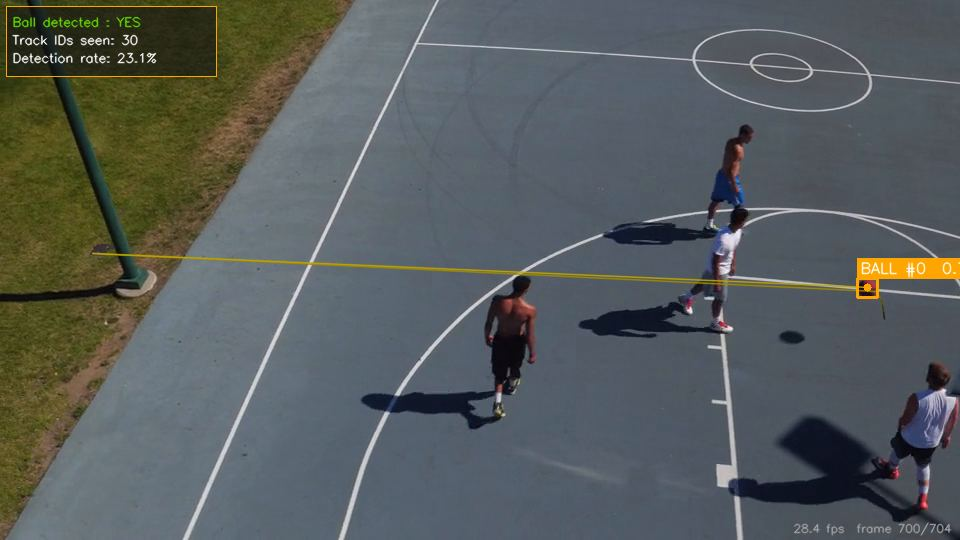

Frame  700/704 | Ball: detected | Track IDs: 30 | Detection rate: 23.1% | 28.4 fps

Tracking complete!
   Frames processed      : 704
   Frames with ball      : 165
   Detection rate        : 23.4%
   Unique track IDs seen : 31
   Total time            : 24.8s  (28.3 fps avg)


In [10]:
import cv2
import numpy as np
from collections import defaultdict, deque
from IPython.display import display, Image as IPImage, clear_output
import time

# Tunable
CONF_THRESHOLD  = 0.15
TRAIL_LENGTH    = 8          # SHORT history — only last 15 frames (was 45)
DISPLAY_EVERY_N = 20
BALL_COLOR      = (0, 165, 255)   # BGR orange
TRAIL_COLOR     = (0, 220, 255)   # BGR yellow
TEXT_COLOR      = (255, 255, 255)
FONT            = cv2.FONT_HERSHEY_SIMPLEX

# Rolling trail buffer — one deque per track ID
track_history     = defaultdict(lambda: deque(maxlen=TRAIL_LENGTH))
last_known_pos    = {}
frames_since_seen = {}
active_track_id   = None   # most recently seen track ID

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f'Cannot open: {VIDEO_PATH}'

W     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS   = cap.get(cv2.CAP_PROP_FPS) or 30.0
TOTAL = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(LOCAL_RAW, fourcc, FPS, (W, H))

print(f'{W}×{H} @ {FPS:.1f} fps | {TOTAL} frames (~{TOTAL/FPS:.1f}s)')
print('Tracking basketball...\n')

frame_idx              = 0
total_frames_with_ball = 0
t0                     = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(
        frame,
        conf=CONF_THRESHOLD,
        classes=[BALL_CLASS_ID],
        tracker=CUSTOM_TRACKER,
        persist=True,
        iou=0.2,
        verbose=False
    )[0]

    ball_detected = False

    if results.boxes is not None and len(results.boxes) > 0:
        for box in results.boxes:
            conf            = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            track_id = int(box.id[0]) if box.id is not None else 0

            track_history[track_id].append((cx, cy))
            last_known_pos[track_id]    = (cx, cy)
            frames_since_seen[track_id] = 0
            active_track_id             = track_id
            ball_detected = True

            # Draw fading trail — thin (max 1px) and short (TRAIL_LENGTH=15)
            trail = track_history[track_id]
            for i in range(1, len(trail)):
                alpha       = i / len(trail)       # 0=oldest, 1=newest
                thickness   = 1                    # always 1px — thin line
                faded_color = (
                    int(TRAIL_COLOR[0] * alpha),
                    int(TRAIL_COLOR[1] * alpha),
                    int(TRAIL_COLOR[2] * alpha),
                )
                cv2.line(frame, trail[i-1], trail[i],
                         faded_color, thickness, cv2.LINE_AA)

            # Bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), BALL_COLOR, 2)
            # Centre dot
            cv2.circle(frame, (cx, cy), 4, BALL_COLOR, -1)
            # Label badge
            label = f'BALL #{track_id}  {conf:.2f}'
            (tw, th), _ = cv2.getTextSize(label, FONT, 0.50, 1)
            cv2.rectangle(frame, (x1, y1-th-8), (x1+tw+6, y1), BALL_COLOR, -1)
            cv2.putText(frame, label, (x1+3, y1-5),
                        FONT, 0.50, TEXT_COLOR, 1, cv2.LINE_AA)

    else:
        # Only draw trail for the most recently active track — not all IDs
        if active_track_id is not None:
            trail = track_history[active_track_id]
            frames_since_seen[active_track_id] = frames_since_seen.get(active_track_id, 0) + 1
            gap = frames_since_seen[active_track_id]

            # Ghost trail — fades over 5 frames
            if gap <= 5 and len(trail) >= 2:
                fade_factor = 1.0 - (gap / 5)
                for i in range(1, len(trail)):
                    alpha       = (i / len(trail)) * fade_factor
                    faded_color = (
                        int(TRAIL_COLOR[0] * alpha * 0.5),
                        int(TRAIL_COLOR[1] * alpha * 0.5),
                        int(TRAIL_COLOR[2] * alpha * 0.5),
                    )
                    cv2.line(frame, trail[i-1], trail[i],
                             faded_color, 1, cv2.LINE_AA)

            # Ghost ring at last known position
            if active_track_id in last_known_pos and gap <= 5:
                cv2.circle(frame, last_known_pos[active_track_id], 8,
                           (80, 80, 80), 2)
    if ball_detected:
        total_frames_with_ball += 1

    # Stats
    elapsed       = max(time.time() - t0, 1e-6)
    fps_live      = frame_idx / elapsed
    progress_pct  = frame_idx / TOTAL * 100 if TOTAL else 0
    detection_pct = total_frames_with_ball / max(frame_idx+1, 1) * 100

    # HUD panel
    panel_lines = [
        f'Ball detected : {"YES" if ball_detected else "NO"}',
        f'Track IDs seen: {len(track_history)}',
        f'Detection rate: {detection_pct:.1f}%',
    ]
    pad, line_h, panel_w = 8, 18, 210
    panel_h = pad*2 + line_h*len(panel_lines)

    overlay = frame.copy()
    cv2.rectangle(overlay, (6,6), (6+panel_w, 6+panel_h), (20,20,20), -1)
    cv2.addWeighted(overlay, 0.6, frame, 0.4, 0, frame)
    cv2.rectangle(frame, (6,6), (6+panel_w, 6+panel_h), BALL_COLOR, 1)
    for i, txt in enumerate(panel_lines):
        col = (0, 220, 100) if (i == 0 and ball_detected) else TEXT_COLOR
        cv2.putText(frame, txt, (12, 6+pad+i*line_h+12),
                    FONT, 0.42, col, 1, cv2.LINE_AA)

    # Speed tag bottom-right
    speed_txt = f'{fps_live:.1f} fps  frame {frame_idx}/{TOTAL}'
    (sw, _), _ = cv2.getTextSize(speed_txt, FONT, 0.38, 1)
    cv2.putText(frame, speed_txt, (W-sw-8, H-8),
                FONT, 0.38, (160,160,160), 1, cv2.LINE_AA)

    writer.write(frame)

    # Notebook preview
    if frame_idx % DISPLAY_EVERY_N == 0:
        clear_output(wait=True)
        _, buf = cv2.imencode('.jpg', frame, [cv2.IMWRITE_JPEG_QUALITY, 78])
        display(IPImage(data=buf.tobytes()))
        print(f'Frame {frame_idx:>4}/{TOTAL} | '
              f'Ball: {"detected" if ball_detected else "not detected"} | '
              f'Track IDs: {len(track_history)} | '
              f'Detection rate: {detection_pct:.1f}% | '
              f'{fps_live:.1f} fps')

    frame_idx += 1

cap.release()
writer.release()

print(f'\nTracking complete!')
print(f'   Frames processed      : {frame_idx}')
print(f'   Frames with ball      : {total_frames_with_ball}')
print(f'   Detection rate        : {total_frames_with_ball/max(frame_idx,1)*100:.1f}%')
print(f'   Unique track IDs seen : {len(track_history)}')
print(f'   Total time            : {elapsed:.1f}s  ({fps_live:.1f} fps avg)')



In [11]:
import shutil

print('Re-encoding to H.264...')
!ffmpeg -y -i {LOCAL_RAW} \
        -vcodec libx264 -crf 22 -preset fast \
        -movflags +faststart \
        {LOCAL_H264} -loglevel error

shutil.copy2(LOCAL_H264, OUTPUT_PATH)

out_mb = os.path.getsize(OUTPUT_PATH) / 1e6
print(f'Saved to Google Drive!')
print(f'MyDrive/Obj_detection_segmentation/{OUTPUT_NAME}  ({out_mb:.1f} MB)')

Re-encoding to H.264...
Saved to Google Drive!
MyDrive/Obj_detection_segmentation/ball_tracking_output_maybegood.mp4  (4.1 MB)


In [12]:
from IPython.display import HTML
from base64 import b64encode

with open(LOCAL_H264, 'rb') as f:
    b64 = b64encode(f.read()).decode()

HTML(f'''
<h3 style="font-family:sans-serif;color:#ff8c00">Basketball Tracking — Output Preview</h3>
<video width="960" controls autoplay loop
       style="border:2px solid #ff8c00;border-radius:8px;max-width:100%;background:#000">
  <source src="data:video/mp4;base64,{b64}" type="video/mp4">
</video>
<p style="font-family:sans-serif;color:#888;font-size:13px">
  Saved → <code>MyDrive/Obj_detection_segmentation/ball_tracking_output.mp4</code>
</p>
''')
